<a href="https://colab.research.google.com/github/ivaben/DS-Unit-2-Kaggle-Challenge/blob/master/IVANA_BERN_assignment_4_Classification_Metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
import matplotlib
print(matplotlib.__version__)

3.1.2


In [0]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [0]:
# Split train into train and val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, stratify=train['status_group'], random_state=42)

In [0]:
# Wrangle train, val, test sets

def wrangle(X):

  X=X.copy()

  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  cols_with_zeros = ['latitude','longitude', 'wpt_name', 'num_private', 'basin',
                     'region_code', 'lga', 'construction_year','ward', 'management_group', 'water_quality', 'waterpoint_type_group', 'population', 'gps_height'
                    ]
  for col in cols_with_zeros:

    X[col] = X[col].replace(0, np.nan)
    X[col+'_MISSING'] = X[col].isnull()

  # Drop duplicate columns
  duplicates = ['quantity_group', 'payment_type', 'source_type']
  X = X.drop(columns=duplicates)

 # Drop recorded_by (never varies) and id (always varies, random)
  unusable_variance = ['recorded_by','id']
  X = X.drop(columns=unusable_variance)

 # Convert date_recorded to datetime
  X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)

 # Extract components from date_recorded, then drop the original column
  X['year_recorded'] = X['date_recorded'].dt.year
  X['month_recorded'] = X['date_recorded'].dt.month
  X['day_recorded'] = X['date_recorded'].dt.day
  X = X.drop(columns='date_recorded')

 # Engineer feature: how many years from construction_year to date_recorded

  X['years'] = X['year_recorded'] - X['construction_year']
  X['years_MISSING'] = X['years'].isnull()
 
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
target = 'status_group'

In [0]:
# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [0]:
# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8106902356902357


In [0]:
import sklearn
sklearn.__version__

'0.21.3'

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[5772,  148,  532],
       [ 474,  248,  141],
       [ 898,   56, 3611]])

In [0]:
# get labels
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [0]:
# 1. Check that our labels are correct
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    return columns, index

plot_confusion_matrix(y_val, y_pred)

(['Predicted functional',
  'Predicted functional needs repair',
  'Predicted non functional'],
 ['Actual functional',
  'Actual functional needs repair',
  'Actual non functional'])

In [0]:
 # 2. Make it a pandas dataframe
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table

plot_confusion_matrix(y_val, y_pred)

,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,5772,148,532
Actual functional needs repair,474,248,141
Actual non functional,898,56,3611


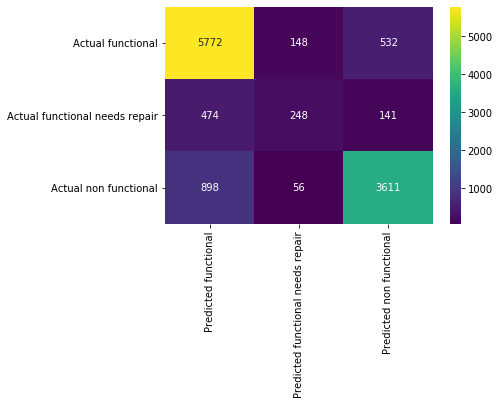

In [0]:
# 3. Plot a heatmap
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, y_pred);

In [0]:
# How many correct predictions were made?
5772+248+3611

9631

In [0]:
# How many total predictions were made?
5772 + 148 + 532 + 474 + 248 + 141 + 898 + 56 + 3611

11880

In [0]:
# What was the classification accuracy?

correct_predictions = 9631
total_predictions = 11880
correct_predictions / total_predictions

0.8106902356902357

In [0]:
accuracy_score(y_val, y_pred)

0.8106902356902357

In [0]:
sum(y_pred == y_val) / len(y_pred)

0.8106902356902357

In [0]:
#  Use classification metrics: precision, recall

from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6452
functional needs repair       0.55      0.29      0.38       863
         non functional       0.84      0.79      0.82      4565

               accuracy                           0.81     11880
              macro avg       0.73      0.66      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



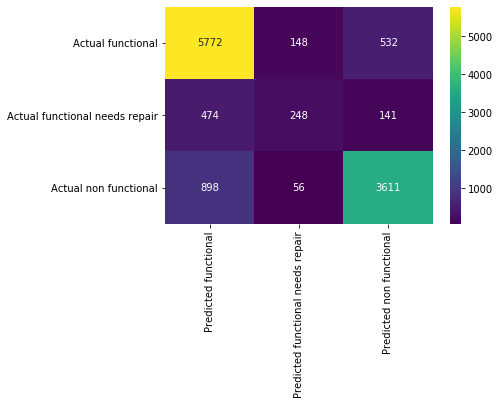

In [0]:
plot_confusion_matrix(y_val, y_pred);

In [0]:
# How many correct predictions of "non functional"?

correct_predictions_nonfunctional = 3611

In [0]:
# How many total predictions of "non functional"?

total_predictions_nonfunctional = 3611 + 141 + 532

In [0]:
# What's the precision for "non functional"?

correct_predictions_nonfunctional / total_predictions_nonfunctional

0.8429038281979458

In [0]:
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.89      0.85      6452
functional needs repair       0.55      0.29      0.38       863
         non functional       0.84      0.79      0.82      4565

               accuracy                           0.81     11880
              macro avg       0.73      0.66      0.68     11880
           weighted avg       0.80      0.81      0.80     11880



In [0]:
# How many actual "non functional" waterpumps?

actual_nonfunctional = 898 + 56 + 3611

In [0]:
# What's the recall for "non functional"?

correct_predictions_nonfunctional / actual_nonfunctional 

0.7910186199342826

In [0]:
# Understand the relationships between precision, recall, thresholds, and predicted probabilities, to help make decisions and allocate budgets

In [0]:
len(test)


14358

In [0]:
len(train) + len(val)

59400

In [0]:
y_train.value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [0]:
# We want to identify which waterpumps are non-functional or are functional but needs repair:

y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543077
True     0.456923
Name: status_group, dtype: float64

In [0]:
len(val) == len(test)

False

In [0]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

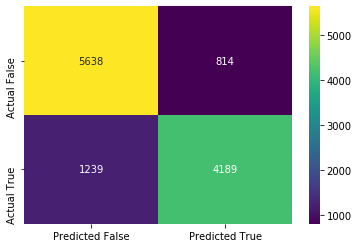

In [0]:
plot_confusion_matrix(y_val, y_pred);

In [0]:
# How many total predictions of "True" ("non functional" or "functional needs repair") ?

4189+814

5003

In [0]:
# Get predicted probabilities and plot the distribution
# Discrete predictions
pipeline.predict(X_val)

array([ True,  True, False, ..., False,  True,  True])

In [0]:
# Predicted probabilities
pipeline.predict_proba(X_val)

array([[0.32, 0.68],
       [0.44, 0.56],
       [0.79, 0.21],
       ...,
       [0.5 , 0.5 ],
       [0.37, 0.63],
       [0.02, 0.98]])

In [153]:
# Predicted probabilities *for the positive class* ...
pipeline.predict_proba(X_val)[:, 1]

array([0.68, 0.56, 0.21, ..., 0.5 , 0.63, 0.98])

In [154]:
# Make predicted probabilities into discrete predictions, using a "threshold"
pipeline.predict_proba(X_val)[:, 1] > 0.5

array([ True,  True, False, ..., False,  True,  True])

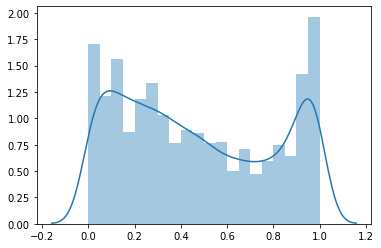

In [155]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
sns.distplot(y_pred_proba);

False    10244
True      1636
dtype: int64

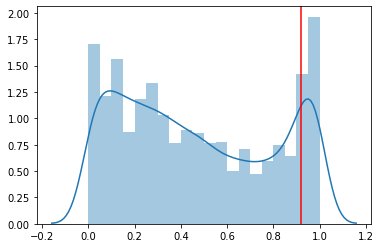

In [156]:
# Change the threshold
threshold = 0.92

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [157]:
from ipywidgets import interact, fixed

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)

interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0, 1, 0.02));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…